In [28]:
import pytesseract
import numpy as np
import re
import csv
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.styles import ParagraphStyle
from reportlab.platypus import Paragraph
import cv2
import pytesseract
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Image processing 

In [46]:
import cv2
import matplotlib.pyplot as plt

# Function to enhance image quality
def enhance_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to separate background from text
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # Invert the thresholded image
    thresholded = cv2.bitwise_not(thresholded)
    
    return thresholded

    # Sharpen the image
    kernel = np.array([
        [-1, -1, -1],
        [-1, 12, -1],  # Increase center weight
        [-1, -1, -1]
    ])
    sharpened = cv2.filter2D(thresholded, -1, kernel)
    
    return sharpened

# Load the image
image_path = "Fine3.jpeg"
image = cv2.imread(image_path)

# Enhance the image quality
enhanced_image = enhance_image(image)




##### Denoiser 

In [24]:
import numpy as np

def denoise_image(enhanced_image):
    denoised_image = cv2.fastNlMeansDenoising(image, None, h=30, templateWindowSize=7, searchWindowSize=21)
    return denoised_image

denoised_image = denoise_image(enhanced_image)


# Check Difference 

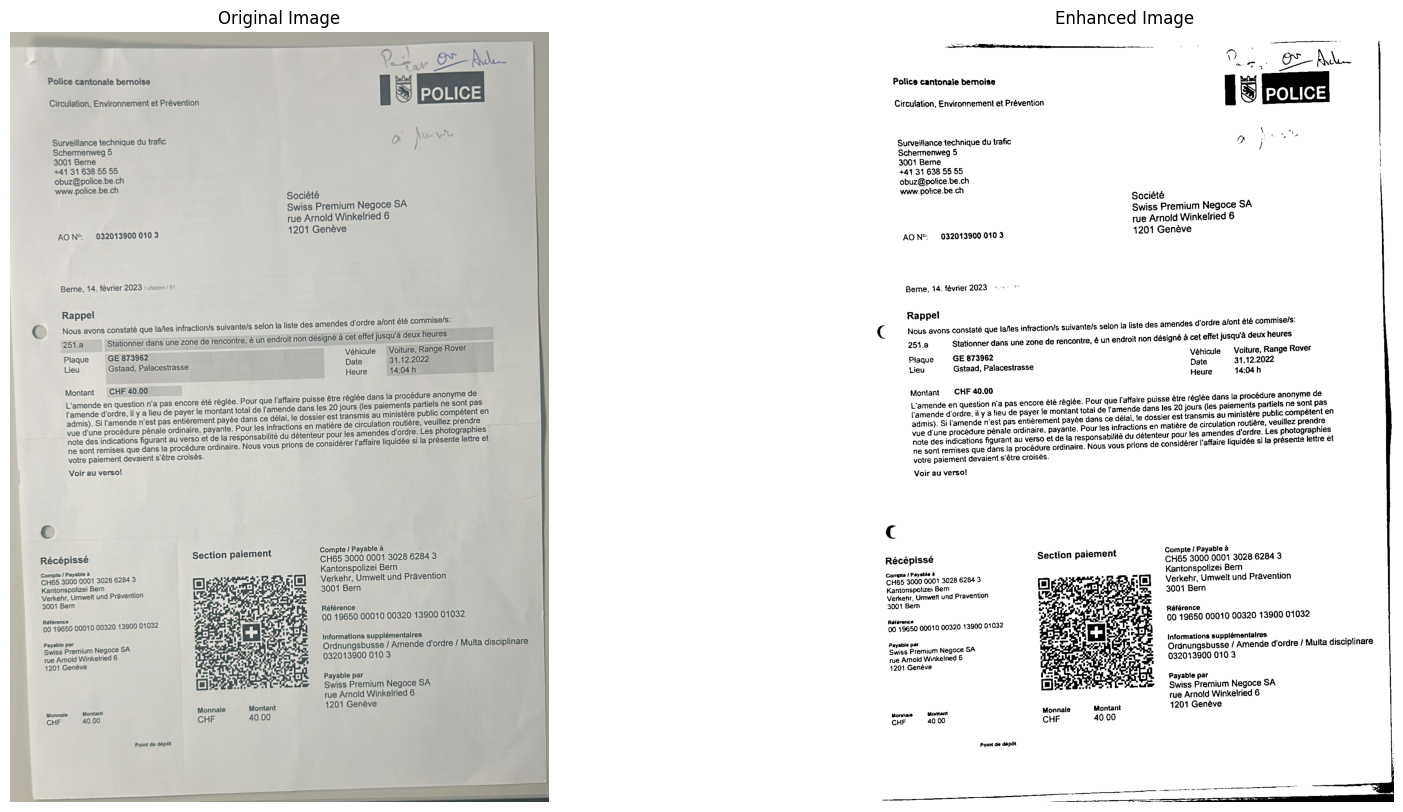

In [47]:
# Plot the original and enhanced images
plt.figure(figsize=(20, 10))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.show()

# Extract Text 

#### Extracting relevant text only 

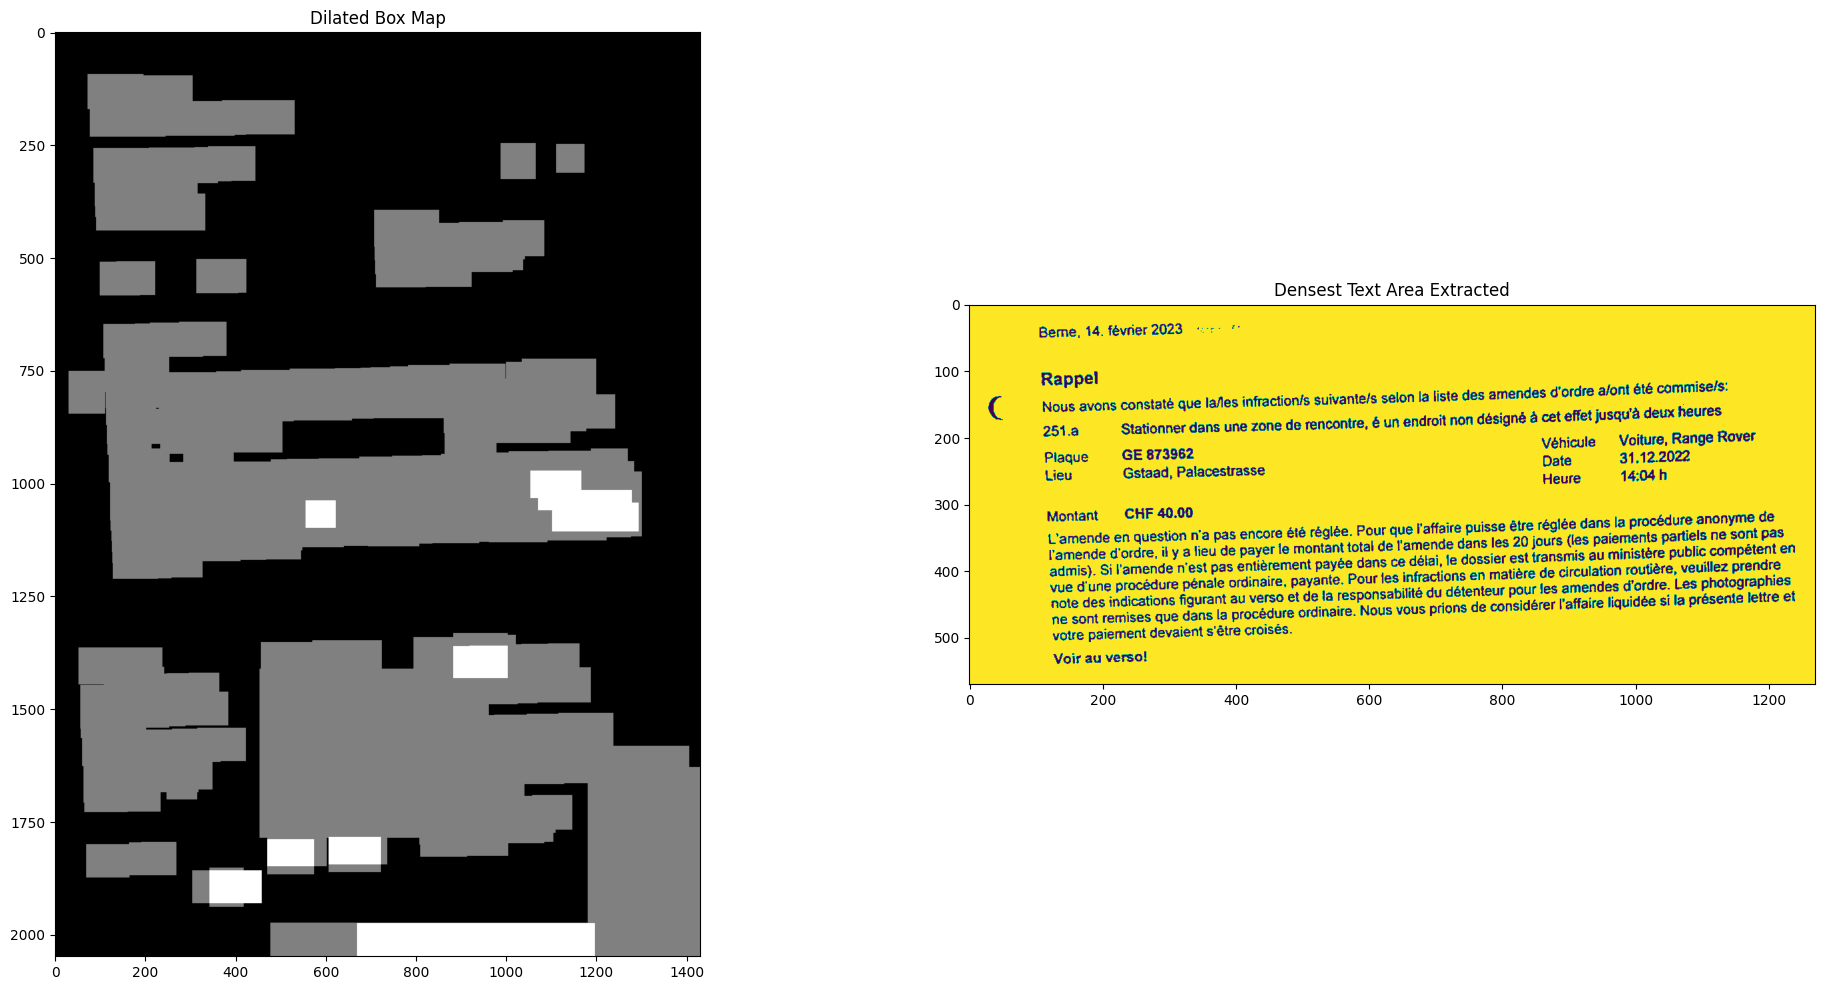

Densest text extracted:
Beme, 14. février 2023

Rappel
Nous avons constaté que lafles infraction/s suivante/s selon la liste des amendes d'ordre a/ont été commise/s:
2514 Stationner dans une zone de rencontre, € un endroit non désigné à cet effet jusqu'à deux heures
Plaque GE 873962 Véhicule Voiture, Range Rover
Lieu Gstaad, Palacestrasse Date 31.12.2022

Heure 14:04h

Montant CHF 40.00

L'amende en question n'a pas encor
l'amende d'ordre, il y a lieu de payer
admis). Si l'amende n'est pas entièrement payée dans ce délai, le d
vue d'une procédure pénale ordinaire, payante. Pour les infractions €:
note des indications figurant au verso et de la responsabilité du détente
ne sont remises que dans la procédure ordinaire. Nous vous prions de considérer l’

votre paiement devaient s'être croisés.

le réglée dans la procédure anonyme de

j {les paiements partiels ne sont pas
ossier est transmis au ministère public compétent en
n matière de circulation routière, veuillez prendre
ur pour les am

In [53]:

def find_densest_text_area(image, config):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    image_np = np.array(image)
    data = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
    box_map = np.zeros(image_np.shape[:2], dtype=np.uint8)

    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 60:
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            box_map[y:y+h, x:x+w] += 1

    kernel_size = 60  # Increase kernel size for more aggressive merging
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    box_map_dilated = cv2.dilate(box_map, kernel, iterations=1)

    threshold_value = np.max(box_map_dilated) * 0.4  # Lower the threshold slightly
    _, box_map_thresholded = cv2.threshold(box_map_dilated, threshold_value, 255, cv2.THRESH_BINARY)

    # Set up the figure with two subplots
    plt.figure(figsize=(24, 12))  # Set the figure size to be wide enough for two subplots
    
    # Subplot for the dilated box map
    plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st subplot)
    plt.imshow(box_map_dilated, cmap='gray')
    plt.title("Dilated Box Map")

    contours, _ = cv2.findContours(box_map_thresholded.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No dense text areas detected.")
        plt.show()
        return None

    img_center_x, img_center_y = image.width // 2, image.height // 2
    max_score = 0
    best_rect = None
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        center_x, center_y = x + w // 2, y + h // 2
        distance = np.sqrt((center_x - img_center_x)**2 + (center_y - img_center_y)**2)
        score = area / (distance + 1)  # Increased weight to area

        if score > max_score:
            max_score = score
            best_rect = (x, y, w, h)

    if not best_rect:
        print("No suitable area found.")
        plt.show()
        return None

    x, y, w, h = best_rect
    densest_area = image.crop((x, y, x + w, y + h))

    # Subplot for the selected densest area
    plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd subplot)
    plt.imshow(densest_area)
    plt.title('Densest Text Area Extracted')
    plt.show()

    densest_text = pytesseract.image_to_string(densest_area, config=config)
    return densest_text

# Assuming 'enhance_image' function returns a PIL Image object
enhanced_image = enhance_image(image)  # where `image` is your input image
config = '--psm 4 -l fra'

densest_text = find_densest_text_area(enhanced_image, config)
if densest_text:
    print("Densest text extracted:")
    print(densest_text)
else:
    print("No text was extracted.")


# Translate from any language to English 

In [50]:
from googletrans import Translator

def translate_to_english(densest_text):
    translator = Translator()

    # Detect language
    detected_lang = translator.detect(densest_text).lang

    # Translate to English if necessary
    if detected_lang != 'en':
        translated_text = translator.translate(densest_text, dest='en').text
    else:
        translated_text = densest_text

    return translated_text

translated_text = translate_to_english(densest_text)
print("Translated Text:", translated_text)



Translated Text: Beme, February 14, 2023

Reminder
We found that the next infraction/s according to the list of fines of order A/were committed/s:
2514 Park in a meeting area, € a place not designated for this purpose up to two hours
Ge 873962 car vehicle, Range Rover
GSTAAD place, palacestras date 31.12.2022

Time 14: 04h

CHF 40.00 Amount

The fine in question has not yet
the fine of order, it is necessary to pay
admitted).If the fine is not fully paid within this period, the D
View of an ordinary, paying criminal procedure.For offenses €:
Note of the indications appearing on the back and the responsibility of the relaxation
are only given in the ordinary procedure.We ask you to consider the

Your payment had to have come across.

set up in the anonymous procedure of

J {Partial payments are not
Ossier is sent to the competent public prosecutor in
n road traffic materials, please take
ur for order fines.Photos
liquidated affair if this letter and

See Versol


# Extreact Features (NLP)

### NER Training

In [107]:
import pandas as pd
import ast

df = pd.read_excel("NERTRAIN.xlsx")

TRAIN_DATA = []

for index, row in df.iterrows():
    text = row['text']
    entities = ast.literal_eval(row['entities'])  # Using the correct column name
    
    entities_list = []
    for ent in entities:
        start = ent['start']
        end = ent['end']
        label = ent['label']
        entities_list.append((start, end, label))
    
    TRAIN_DATA.append((text, {"entities": entities_list}))

#### Regular Expressions Approach

In [ ]:
# Regex patterns to extract desired information
patterns = {
    'Vehicule': r'Véhicule:\s*([A-Z]+\s+\d+)',
    'Date/Heure': r'Date/Heure:\s*(.*?)\sà',
    'Vitesse autorisée': r'Vitesse autorisée:\s*(\d+)\s+km/h',
    'Vitesse mesurée': r'Vitesse mesurée:\s*(\d+)\s+km/h'
}

# Extract information using regex
extracted_info = {}
for key, pattern in patterns.items():
    match = re.search(pattern, text)
    if match:
        extracted_info[key] = match.group(1)

# Search for plate number pattern in the extracted text
plate_number_pattern = r'\b[A-Z]{2}\s+\d+\b'
plate_number_match = re.search(plate_number_pattern, text)
if plate_number_match:
    plate_number = plate_number_match.group()
    # Check if the plate number is the same as the vehicle
    if 'Vehicule' in extracted_info:
        vehicule = extracted_info['Vehicule']
        if vehicule == plate_number:
            # If the plate number and Véhicule are the same, only include one of them
            extracted_info.pop('Vehicule', None)
            extracted_info['Plate number'] = plate_number
        else:
            extracted_info['Plate number'] = plate_number
    else:
        extracted_info['Plate number'] = plate_number

# Print extracted information
print(extracted_info)

In [64]:
# Regex patterns to extract desired information
patterns = {
    'Vehicule': r'Véhicule:\s*([A-Z]+\s+\d+)',
    'Date/Heure': r'Date/Heure:\s*(.*?)\sà',
    'Vitesse autorisée': r'Vitesse autorisée:\s*(\d+)\s+km/h',
    'Vitesse mesurée': r'Vitesse mesurée:\s*(\d+)\s+km/h'
}

# Extract information using regex
extracted_info = {}
for key, pattern in patterns.items():
    match = re.search(pattern, text)
    if match:
        extracted_info[key] = match.group(1)

# Search for plate number pattern in the extracted text
plate_number_pattern = r'\b[A-Z]{2}\s+\d+\b'
plate_number_match = re.search(plate_number_pattern, text)
if plate_number_match:
    plate_number = plate_number_match.group()
    # Check if the plate number is the same as the vehicle
    if 'Vehicule' in extracted_info:
        vehicule = extracted_info['Vehicule']
        if vehicule == plate_number:
            # If the plate number and Véhicule are the same, only include one of them
            extracted_info.pop('Vehicule', None)
            extracted_info['Plate number'] = plate_number
        else:
            extracted_info['Plate number'] = plate_number
    else:
        extracted_info['Plate number'] = plate_number

# Print extracted information
print(extracted_info)

{'Plate number': 'SA 1410'}


# Fine Estimation

In [30]:
from FineEstimator import estimate_fine  
# Convert extracted speed values to integers
vitesse_autorisee = int(extracted_info.get('Vitesse autorisée', 0))
vitesse_mesuree = int(extracted_info.get('Vitesse mesurée', 0))

# Estimate fine based on extracted information
if vitesse_autorisee and vitesse_mesuree:
    # Calculate actual speeding
    speeding = vitesse_mesuree - vitesse_autorisee
    print("Actual Speeding:", speeding)
    
    # Estimate fine based on actual speeding
    fine_estimate = estimate_fine(vitesse_autorisee, vitesse_mesuree)
    print("Fine Estimate:", fine_estimate)
else:
    print("Unable to estimate fine.")


Actual Speeding: 26
Fine Estimate: Potential criminal offense
